# 0. GENERATE SAMPLE DATA

## 1. LOAD AND VISUALIZE RAW TIME SERIES DATA

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           roc_auc_score, roc_curve, precision_recall_curve, f1_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Feature engineering
from scipy import signal
from scipy.stats import skew, kurtosis
import pickle

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.3


In [2]:
# Cell 2: Data Loading and Merging
def load_and_merge_data(filepath='dataset/out.csv'):
    """
    Load and merge sensor measurements by timestamp
    """
    print("Loading data...")
    df = pd.read_csv("dataset/merged_data.csv")
    
    print(f"Original shape: {df.shape}")
    print(f"Original rows: {len(df):,}")
    
    # Convert timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Convert string columns to numeric
    numeric_columns = ['voltage_l1', 'voltage_l2', 'voltage_l3', 'temperatur', 
                      'currentl1', 'activepower', 'apparentpower', 'reactivepower']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Merge by timestamp - taking first non-null value
    print("\nMerging measurements by timestamp...")
    merged_df = df.groupby('timestamp').first().reset_index()
    
    print(f"Merged shape: {merged_df.shape}")
    print(f"Merged rows: {len(merged_df):,}")
    print(f"Reduction ratio: {len(df)/len(merged_df):.2f}x")
    
    return merged_df

# Load data
df = load_and_merge_data('out.csv')
print("\nFirst few rows:")
df.head()

Loading data...
Original shape: (1378859, 31)
Original rows: 1,378,859

Merging measurements by timestamp...
Merged shape: (679841, 31)
Merged rows: 679,841
Reduction ratio: 2.03x

First few rows:


,timestamp,voltage_l1,voltage_l2,voltage_l3,location,source_file,sensor_id,temperatur,source_file_temperatur_messung_2025-05-30,currentl1,...,location_power_messung_2025-05-30,source_file_power_messung_2025-05-30,location_druck_messung_2025-05-30,value,source_file_druck_messung_2025-05-30,location_velocity_messung_2025-05-30,countervelo,frequencyvelo,periodvelo,source_file_velocity_messung_2025-05-30
0,2025-05-30 14:00:53.952000+02:00,NaN,NaN,NaN,None,None,Temperature0,NaN,temperatur_messung_2025-05-30,NaN,...,None,None,None,NaN,None,None,NaN,NaN,NaN,None
1,2025-05-30 14:00:53.962000+02:00,NaN,NaN,NaN,None,None,Temperature0,NaN,temperatur_messung_2025-05-30,NaN,...,None,None,None,NaN,None,None,NaN,NaN,NaN,None
2,2025-05-30 14:00:53.972000+02:00,NaN,NaN,NaN,None,None,Temperature0,NaN,temperatur_messung_2025-05-30,0.1566,...,None,None,None,NaN,None,None,NaN,NaN,NaN,None
3,2025-05-30 14:00:53.982000+02:00,NaN,NaN,NaN,None,None,Temperature2,NaN,temperatur_messung_2025-05-30,0.1564,...,None,None,None,NaN,None,Halle 10 Testaufbau,12093.0,0.0,-2.147484e+09,velocity_messung_2025-05-30
4,2025-05-30 14:00:53.992000+02:00,NaN,NaN,NaN,None,None,Temperature0,NaN,temperatur_messung_2025-05-30,0.1564,...,None,None,None,NaN,None,Halle 10 Testaufbau,12093.0,0.0,-2.147484e+09,velocity_messung_2025-05-30


In [3]:
# Cell 3: Create Target Variable (Simulated for demonstration)
def create_target_variable(df):
    """
    Create a target variable for drill sharpness based on sensor patterns.
    In production, this would come from actual labels/measurements.
    
    Sharp drill characteristics:
    - Lower vibration
    - Lower current draw
    - Lower temperature
    - More stable power consumption
    """
    
    # Calculate rolling statistics for key indicators
    window_size = 100  # Adjust based on your sampling rate
    
    # Vibration indicator (lower is sharper)
    if 'wert' in df.columns:
        vibration_score = df['wert'].rolling(window=window_size, min_periods=1).mean().fillna(df['wert'].mean())
        vibration_percentile = vibration_score.rank(pct=True)
    else:
        vibration_percentile = 0.5
    
    # Current indicator (lower is sharper)
    current_cols = ['currentl1', 'currentl2', 'currentl3']
    existing_current = [col for col in current_cols if col in df.columns]
    if existing_current:
        df['avg_current'] = df[existing_current].mean(axis=1)
        current_score = df['avg_current'].rolling(window=window_size, min_periods=1).mean().fillna(df['avg_current'].mean())
        current_percentile = current_score.rank(pct=True)
    else:
        current_percentile = 0.5
    
    # Temperature indicator (lower is sharper)
    if 'temperatur' in df.columns:
        temp_score = df['temperatur'].rolling(window=window_size, min_periods=1).mean().fillna(df['temperatur'].mean())
        temp_percentile = temp_score.rank(pct=True)
    else:
        temp_percentile = 0.5
    
    # Power stability indicator (more stable is sharper)
    if 'activepower' in df.columns:
        power_std = df['activepower'].rolling(window=window_size, min_periods=1).std().fillna(0)
        power_stability_percentile = 1 - power_std.rank(pct=True)
    else:
        power_stability_percentile = 0.5
    
    # Combine scores (lower total score = sharper drill)
    total_score = (vibration_percentile + current_percentile + 
                  temp_percentile + (1 - power_stability_percentile)) / 4
    
    # Create binary classification
    # Bottom 40% = Sharp (0), Top 40% = Dull (1), Middle 20% removed for clearer separation
    df['drill_condition_score'] = total_score
    df['is_dull'] = np.nan
    df.loc[total_score <= 0.4, 'is_dull'] = 0  # Sharp
    df.loc[total_score >= 0.6, 'is_dull'] = 1  # Dull
    
    # Remove middle ground for clearer classification
    df_classified = df.dropna(subset=['is_dull'])
    df_classified['is_dull'] = df_classified['is_dull'].astype(int)
    
    print(f"Samples labeled as Sharp: {(df_classified['is_dull'] == 0).sum():,}")
    print(f"Samples labeled as Dull: {(df_classified['is_dull'] == 1).sum():,}")
    print(f"Samples removed (ambiguous): {len(df) - len(df_classified):,}")
    
    return df_classified

# Create target variable
df = create_target_variable(df)
print(f"\nFinal dataset shape: {df.shape}")

Samples labeled as Sharp: 210,875
Samples labeled as Dull: 196,974
Samples removed (ambiguous): 271,992

Final dataset shape: (407849, 34)


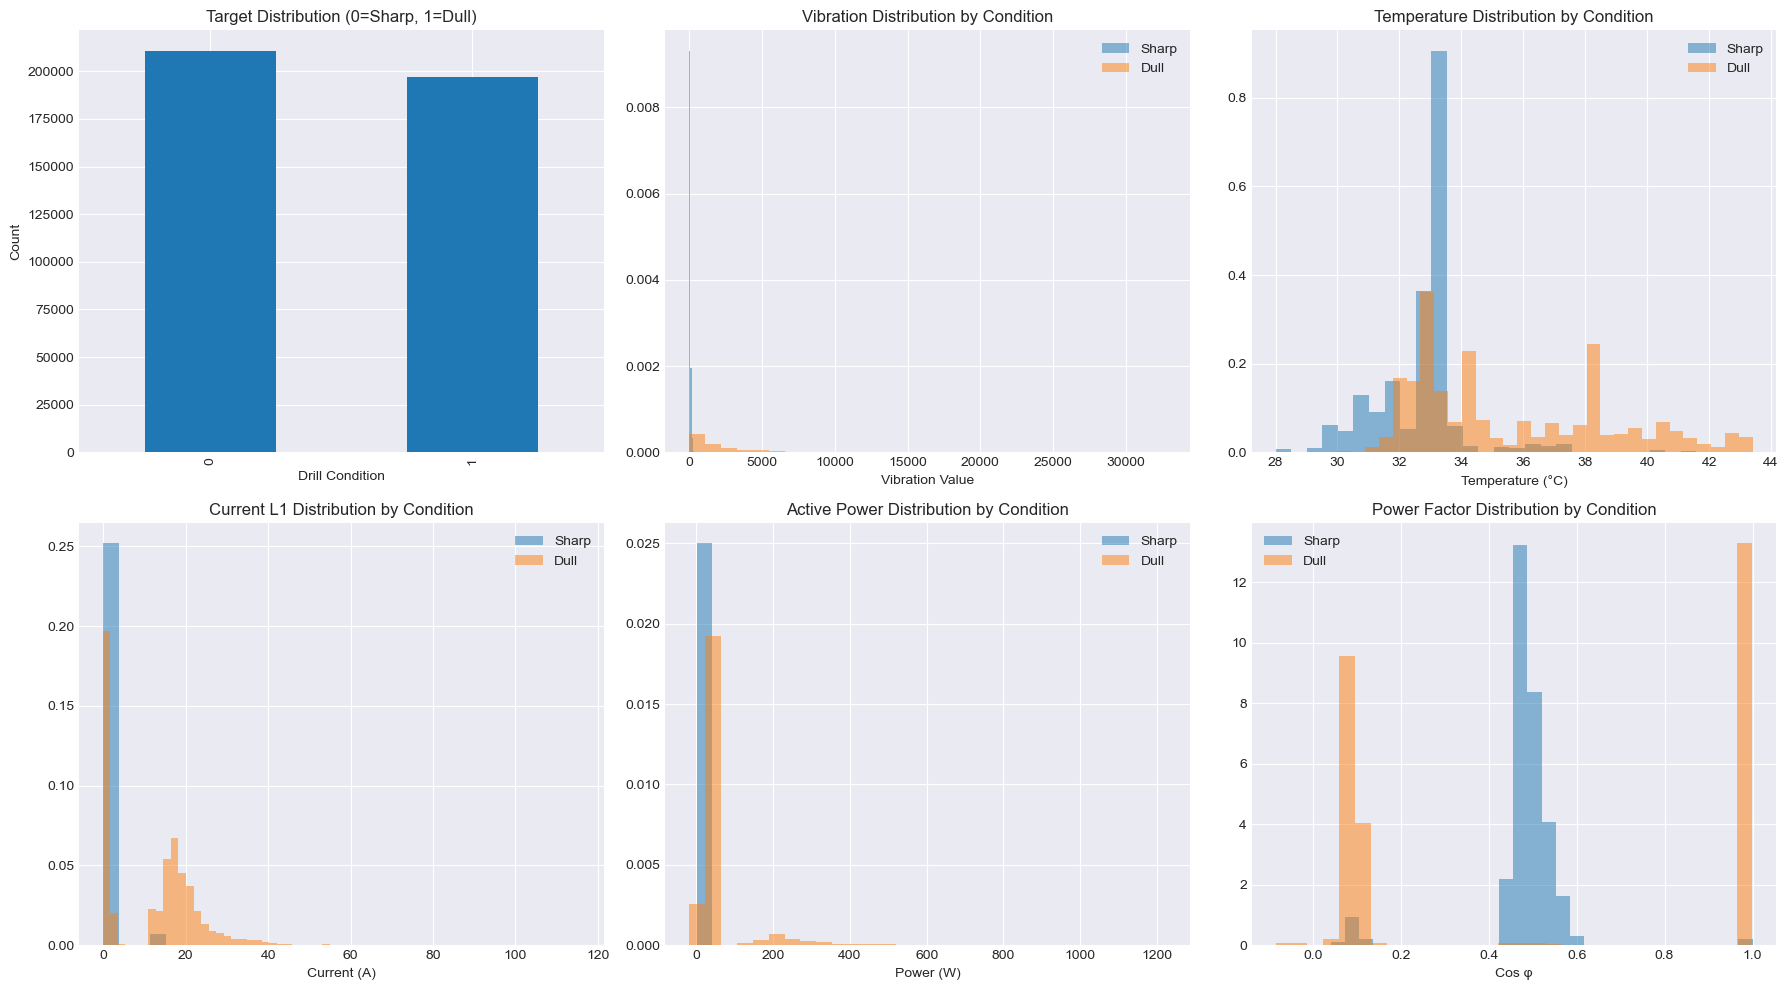

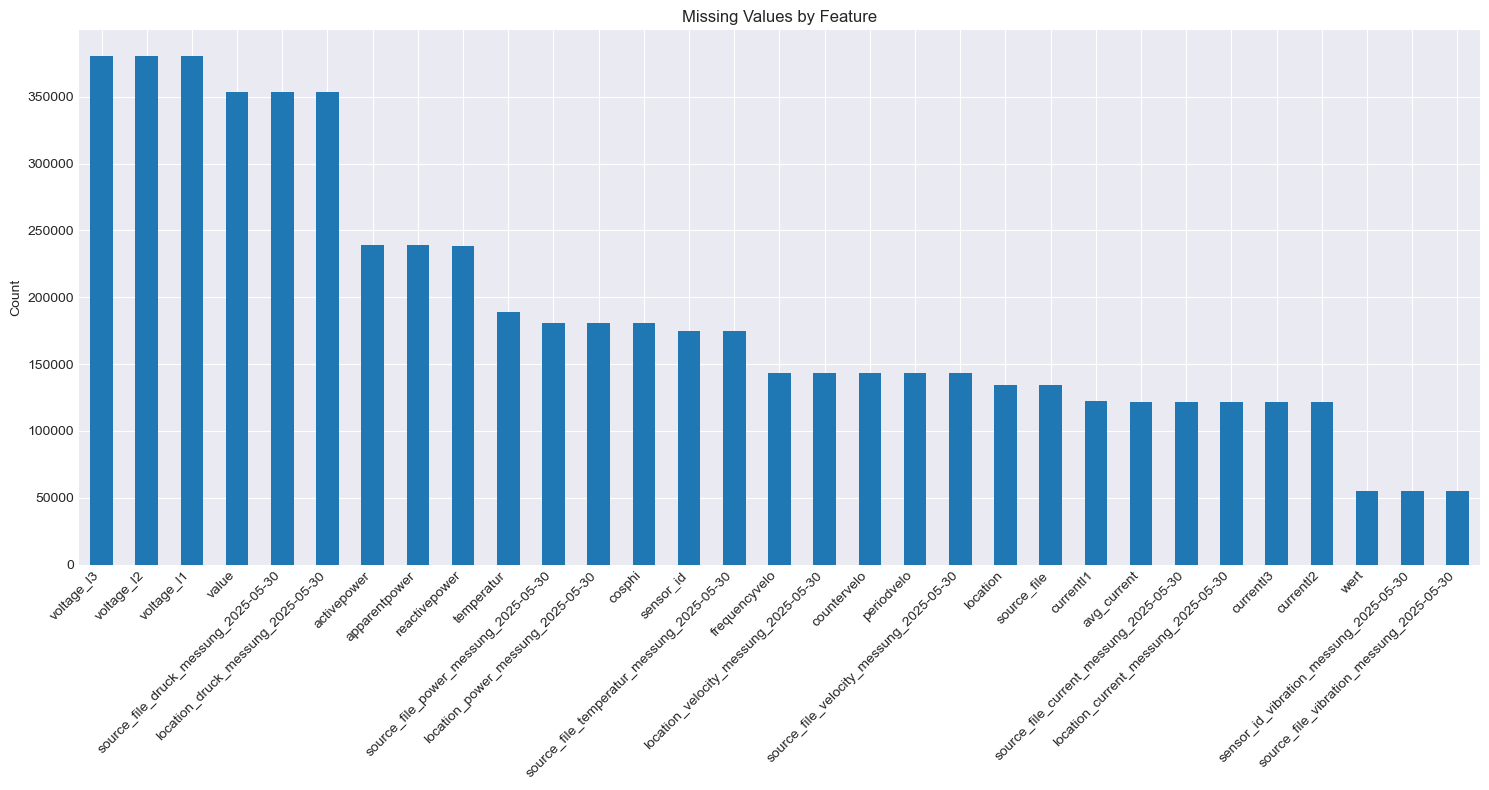


=== Statistical Summary by Drill Condition ===

wert:
                mean          std  min      max
is_dull                                        
0          44.851733    92.499187  0.0   2557.0
1        2200.447030  3054.166552  0.0  32767.0

temperatur:
              mean       std   min   max
is_dull                                 
0        32.732786  1.356710  28.0  43.1
1        35.649419  3.218569  30.0  43.4

currentl1:
              mean        std     min      max
is_dull                                       
0         0.392670   2.099362 -0.1470  115.658
1        11.954307  10.573267 -0.1555   54.998

currentl2:
             mean       std     min     max
is_dull                                    
0        0.491866  0.032327  0.4178  0.5703
1        0.505329  0.021837  0.4308  0.5693

currentl3:
             mean       std     min     max
is_dull                                    
0        0.016655  0.002171  0.0114  0.1284
1        0.024552  0.007848  0.0106  0.0653


In [4]:
# Cell 4: Exploratory Data Analysis
def perform_eda(df):
    """
    Comprehensive exploratory data analysis
    """
    # Set up the plotting style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # 1. Target distribution
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Target distribution
    ax = axes[0, 0]
    df['is_dull'].value_counts().plot(kind='bar', ax=ax)
    ax.set_title('Target Distribution (0=Sharp, 1=Dull)')
    ax.set_xlabel('Drill Condition')
    ax.set_ylabel('Count')
    
    # Key sensor distributions by target
    # Vibration
    if 'wert' in df.columns:
        ax = axes[0, 1]
        df[df['is_dull']==0]['wert'].hist(alpha=0.5, bins=30, label='Sharp', ax=ax, density=True)
        df[df['is_dull']==1]['wert'].hist(alpha=0.5, bins=30, label='Dull', ax=ax, density=True)
        ax.set_title('Vibration Distribution by Condition')
        ax.set_xlabel('Vibration Value')
        ax.legend()
    
    # Temperature
    if 'temperatur' in df.columns:
        ax = axes[0, 2]
        df[df['is_dull']==0]['temperatur'].hist(alpha=0.5, bins=30, label='Sharp', ax=ax, density=True)
        df[df['is_dull']==1]['temperatur'].hist(alpha=0.5, bins=30, label='Dull', ax=ax, density=True)
        ax.set_title('Temperature Distribution by Condition')
        ax.set_xlabel('Temperature (°C)')
        ax.legend()
    
    # Current
    if 'currentl1' in df.columns:
        ax = axes[1, 0]
        df[df['is_dull']==0]['currentl1'].hist(alpha=0.5, bins=30, label='Sharp', ax=ax, density=True)
        df[df['is_dull']==1]['currentl1'].hist(alpha=0.5, bins=30, label='Dull', ax=ax, density=True)
        ax.set_title('Current L1 Distribution by Condition')
        ax.set_xlabel('Current (A)')
        ax.legend()
    
    # Power
    if 'activepower' in df.columns:
        ax = axes[1, 1]
        df[df['is_dull']==0]['activepower'].hist(alpha=0.5, bins=30, label='Sharp', ax=ax, density=True)
        df[df['is_dull']==1]['activepower'].hist(alpha=0.5, bins=30, label='Dull', ax=ax, density=True)
        ax.set_title('Active Power Distribution by Condition')
        ax.set_xlabel('Power (W)')
        ax.legend()
    
    # Power Factor
    if 'cosphi' in df.columns:
        ax = axes[1, 2]
        df[df['is_dull']==0]['cosphi'].hist(alpha=0.5, bins=30, label='Sharp', ax=ax, density=True)
        df[df['is_dull']==1]['cosphi'].hist(alpha=0.5, bins=30, label='Dull', ax=ax, density=True)
        ax.set_title('Power Factor Distribution by Condition')
        ax.set_xlabel('Cos φ')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 2. Missing data analysis
    plt.figure(figsize=(15, 8))
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if len(missing) > 0:
        missing.plot(kind='bar')
        plt.title('Missing Values by Feature')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
    else:
        plt.text(0.5, 0.5, 'No missing values!', ha='center', va='center', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    # 3. Statistical summary by target
    print("\n=== Statistical Summary by Drill Condition ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    important_cols = ['wert', 'temperatur', 'currentl1', 'currentl2', 'currentl3', 
                     'activepower', 'cosphi', 'value', 'frequencyvelo']
    cols_to_analyze = [col for col in important_cols if col in numeric_cols]
    
    for col in cols_to_analyze:
        print(f"\n{col}:")
        print(df.groupby('is_dull')[col].describe()[['mean', 'std', 'min', 'max']])
    
    return df

# Perform EDA
df = perform_eda(df)

In [5]:
# Cell 5: Feature Engineering
def engineer_features(df, window_sizes=[10, 50, 100]):
    """
    Create advanced features for better classification
    """
    print("Starting feature engineering...")
    
    # Store original columns
    original_cols = df.columns.tolist()
    
    # 1. Rolling statistics for each numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['is_dull', 'drill_condition_score']]
    
    for window in window_sizes:
        print(f"Creating rolling features with window={window}")
        for col in numeric_cols:
            if df[col].notna().sum() > window:  # Check if enough data
                # Rolling mean
                df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
                # Rolling std
                df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
                # Rolling min-max range
                df[f'{col}_roll_range_{window}'] = (df[col].rolling(window=window, min_periods=1).max() - 
                                                     df[col].rolling(window=window, min_periods=1).min())
    
    # 2. Rate of change features
    print("Creating rate of change features...")
    for col in numeric_cols:
        if df[col].notna().sum() > 1:
            df[f'{col}_diff'] = df[col].diff()
            df[f'{col}_pct_change'] = df[col].pct_change()
    
    # 3. Frequency domain features (for vibration and similar signals)
    print("Creating frequency domain features...")
    signal_cols = ['wert', 'frequencyvelo', 'periodvelo']
    for col in signal_cols:
        if col in df.columns and df[col].notna().sum() > 100:
            # Use smaller segments for FFT
            segment_size = 64
            fft_features = []
            for i in range(0, len(df) - segment_size, segment_size):
                segment = df[col].iloc[i:i+segment_size].fillna(method='ffill').fillna(0)
                if len(segment) == segment_size:
                    fft = np.fft.fft(segment)
                    fft_features.append([
                        np.mean(np.abs(fft)),  # Mean frequency magnitude
                        np.max(np.abs(fft)),   # Peak frequency magnitude
                        np.std(np.abs(fft))    # Frequency spread
                    ])
            
            # Pad or trim to match dataframe length
            while len(fft_features) < len(df):
                fft_features.append(fft_features[-1] if fft_features else [0, 0, 0])
            fft_features = fft_features[:len(df)]
            
            fft_array = np.array(fft_features)
            df[f'{col}_fft_mean'] = fft_array[:, 0]
            df[f'{col}_fft_max'] = fft_array[:, 1]
            df[f'{col}_fft_std'] = fft_array[:, 2]
    
    # 4. Cross-feature interactions
    print("Creating interaction features...")
    if 'activepower' in df.columns and 'currentl1' in df.columns:
        df['power_current_ratio'] = df['activepower'] / (df['currentl1'] + 1e-10)
    
    if 'temperatur' in df.columns and 'wert' in df.columns:
        df['temp_vibration_product'] = df['temperatur'] * df['wert']
    
    if all(col in df.columns for col in ['voltage_l1', 'voltage_l2', 'voltage_l3']):
        df['voltage_imbalance'] = df[['voltage_l1', 'voltage_l2', 'voltage_l3']].std(axis=1)
    
    if all(col in df.columns for col in ['currentl1', 'currentl2', 'currentl3']):
        df['current_imbalance'] = df[['currentl1', 'currentl2', 'currentl3']].std(axis=1)
        df['total_current'] = df[['currentl1', 'currentl2', 'currentl3']].sum(axis=1)
    
    # 5. Statistical features
    print("Creating statistical features...")
    for col in numeric_cols:
        if df[col].notna().sum() > 10:
            # Skewness and kurtosis over rolling windows
            df[f'{col}_skew'] = df[col].rolling(window=50, min_periods=1).apply(skew)
            df[f'{col}_kurtosis'] = df[col].rolling(window=50, min_periods=1).apply(kurtosis)
    
    # Fill any NaN values created during feature engineering
    df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    print(f"Feature engineering complete!")
    print(f"Original features: {len(original_cols)}")
    print(f"New total features: {len(df.columns)}")
    print(f"Features added: {len(df.columns) - len(original_cols)}")
    
    return df

# Engineer features
df = engineer_features(df)

Starting feature engineering...
Creating rolling features with window=10
Creating rolling features with window=50
Creating rolling features with window=100
Creating rate of change features...
Creating frequency domain features...
Creating interaction features...
Creating statistical features...
Feature engineering complete!
Original features: 34
New total features: 269
Features added: 235


In [6]:
# Cell 6: Data Preparation and Train-Test-Val Split
def prepare_data(df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Prepare data for machine learning
    """
    # Remove non-numeric columns and target-related columns
    exclude_cols = ['timestamp', 'is_dull', 'drill_condition_score', 'location', 
                   'source_file', 'sensor_id'] + [col for col in df.columns if 'source_file' in col or 'location' in col]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64']]
    
    # Remove columns with all NaN or zero variance
    valid_features = []
    for col in feature_cols:
        if df[col].notna().any() and df[col].std() > 0:
            valid_features.append(col)
    
    print(f"Valid features for modeling: {len(valid_features)}")
    
    X = df[valid_features]
    y = df['is_dull']
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Second split: separate train and validation
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
    )
    
    print(f"\nDataset splits:")
    print(f"Training set: {X_train.shape[0]:,} samples")
    print(f"Validation set: {X_val.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")
    
    print(f"\nClass distribution:")
    print(f"Train - Sharp: {(y_train==0).sum():,}, Dull: {(y_train==1).sum():,}")
    print(f"Val - Sharp: {(y_val==0).sum():,}, Dull: {(y_val==1).sum():,}")
    print(f"Test - Sharp: {(y_test==0).sum():,}, Dull: {(y_test==1).sum():,}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, valid_features

# Prepare data
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = prepare_data(df)

Valid features for modeling: 244

Dataset splits:
Training set: 244,709 samples
Validation set: 81,570 samples
Test set: 81,570 samples

Class distribution:
Train - Sharp: 126,525, Dull: 118,184
Val - Sharp: 42,175, Dull: 39,395
Test - Sharp: 42,175, Dull: 39,395


Scaling features...

Applying PCA (variance threshold: 0.95)...
Original features: 244
PCA components: 85
Variance explained: 0.951


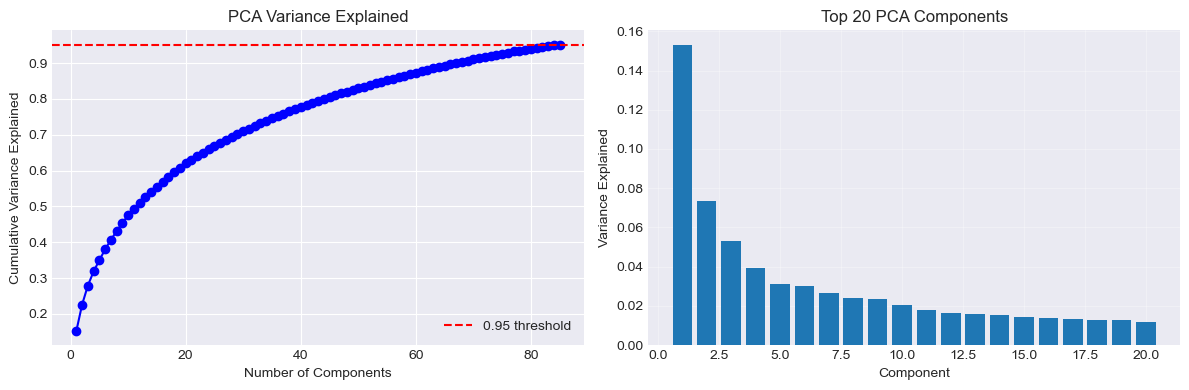

In [7]:
# Cell 7: Feature Scaling and Dimensionality Reduction
def scale_and_reduce_features(X_train, X_val, X_test, variance_threshold=0.95, use_pca=True):
    """
    Scale features and optionally apply PCA
    """
    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    if use_pca:
        print(f"\nApplying PCA (variance threshold: {variance_threshold})...")
        pca = PCA(n_components=variance_threshold, svd_solver='full')
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_val_pca = pca.transform(X_val_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        print(f"Original features: {X_train_scaled.shape[1]}")
        print(f"PCA components: {X_train_pca.shape[1]}")
        print(f"Variance explained: {pca.explained_variance_ratio_.sum():.3f}")
        
        # Visualize PCA variance
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(range(1, len(cumvar) + 1), cumvar, 'bo-')
        plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold} threshold')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance Explained')
        plt.title('PCA Variance Explained')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.bar(range(1, min(21, len(pca.explained_variance_ratio_) + 1)), 
                pca.explained_variance_ratio_[:20])
        plt.xlabel('Component')
        plt.ylabel('Variance Explained')
        plt.title('Top 20 PCA Components')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return (X_train_pca, X_val_pca, X_test_pca, scaler, pca)
    else:
        return (X_train_scaled, X_val_scaled, X_test_scaled, scaler, None)

# Scale and reduce features
X_train_processed, X_val_processed, X_test_processed, scaler, pca = scale_and_reduce_features(
    X_train, X_val, X_test, variance_threshold=0.95, use_pca=True
)

Training baseline models...

Training Logistic Regression...
  Train Accuracy: 0.9874
  Val Accuracy: 0.9871
  Val F1-Score: 0.9866
  Val AUC-ROC: 0.9986
  Training Time: 4.62 seconds

Training Random Forest...
  Train Accuracy: 1.0000
  Val Accuracy: 0.9984
  Val F1-Score: 0.9984
  Val AUC-ROC: 1.0000
  Training Time: 86.47 seconds

Training Gradient Boosting...
  Train Accuracy: 0.9867
  Val Accuracy: 0.9855
  Val F1-Score: 0.9850
  Val AUC-ROC: 0.9986
  Training Time: 1737.15 seconds

Training SVM...
  Train Accuracy: 0.9980
  Val Accuracy: 0.9971
  Val F1-Score: 0.9970
  Val AUC-ROC: 0.9999
  Training Time: 5701.93 seconds

Training XGBoost...
  Train Accuracy: 1.0000
  Val Accuracy: 0.9989
  Val F1-Score: 0.9989
  Val AUC-ROC: 1.0000
  Training Time: 6.11 seconds

Training Neural Network...
  Train Accuracy: 0.9997
  Val Accuracy: 0.9986
  Val F1-Score: 0.9986
  Val AUC-ROC: 0.9999
  Training Time: 383.71 seconds


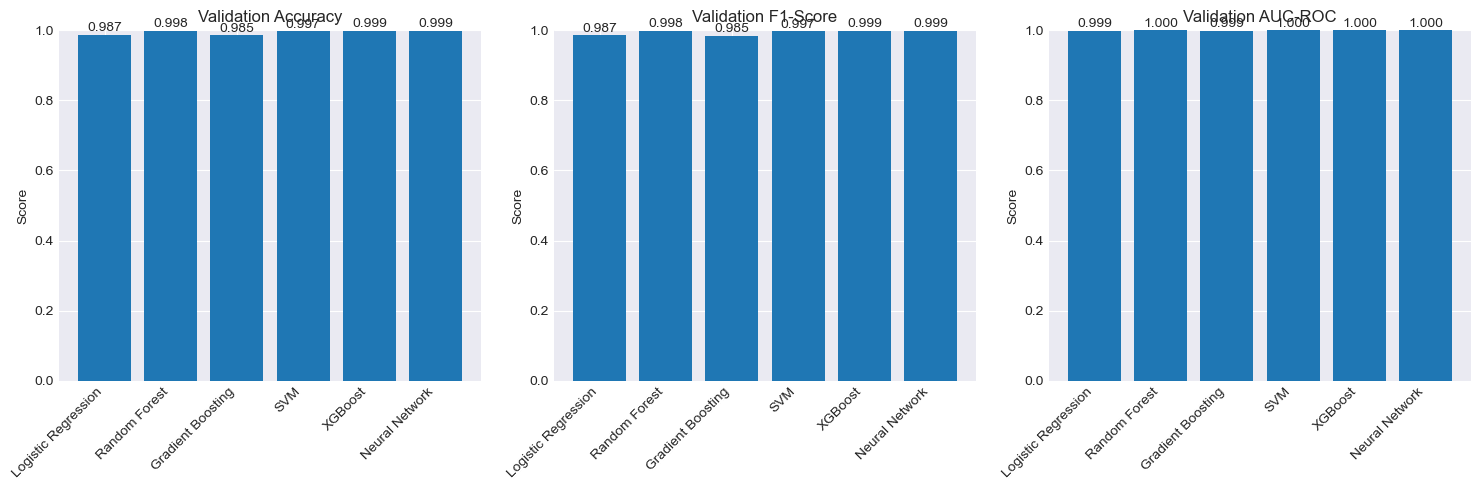

In [8]:
# Cell 8: Model Training - Baseline Models
def train_baseline_models(X_train, y_train, X_val, y_val):
    """
    Train multiple baseline models and compare performance
    """
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000)
    }
    
    results = {}
    
    print("Training baseline models...")
    print("=" * 60)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        start_time = datetime.now()
        model.fit(X_train, y_train)
        train_time = (datetime.now() - start_time).total_seconds()
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_val_proba = model.predict_proba(X_val)[:, 1]
        
        # Metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_proba)
        
        results[name] = {
            'model': model,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_auc': val_auc,
            'train_time': train_time
        }
        
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Val Accuracy: {val_acc:.4f}")
        print(f"  Val F1-Score: {val_f1:.4f}")
        print(f"  Val AUC-ROC: {val_auc:.4f}")
        print(f"  Training Time: {train_time:.2f} seconds")
    
    # Comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    models_list = list(results.keys())
    metrics = ['val_acc', 'val_f1', 'val_auc']
    titles = ['Validation Accuracy', 'Validation F1-Score', 'Validation AUC-ROC']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        values = [results[m][metric] for m in models_list]
        axes[idx].bar(range(len(models_list)), values)
        axes[idx].set_xticks(range(len(models_list)))
        axes[idx].set_xticklabels(models_list, rotation=45, ha='right')
        axes[idx].set_ylabel('Score')
        axes[idx].set_title(title)
        axes[idx].set_ylim([0, 1])
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Train baseline models
baseline_results = train_baseline_models(X_train_processed, y_train, X_val_processed, y_val)

In [9]:
# Cell 9: Hyperparameter Tuning for Best Models
def hyperparameter_tuning(X_train, y_train, X_val, y_val, top_models=2):
    """
    Perform hyperparameter tuning on the best performing models
    """
    # Select top models based on validation accuracy
    sorted_models = sorted(baseline_results.items(), key=lambda x: x[1]['val_auc'], reverse=True)
    top_model_names = [m[0] for m in sorted_models[:top_models]]
    
    print(f"Performing hyperparameter tuning for: {', '.join(top_model_names)}")
    print("=" * 60)
    
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
    
    tuned_models = {}
    
    for model_name in top_model_names:
        if model_name in param_grids:
            print(f"\nTuning {model_name}...")
            
            if model_name == 'Random Forest':
                base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
            elif model_name == 'XGBoost':
                base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
            elif model_name == 'Gradient Boosting':
                base_model = GradientBoostingClassifier(random_state=42)
            
            # Use fewer CV folds for faster tuning
            cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            
            grid_search = GridSearchCV(
                base_model,
                param_grids[model_name],
                cv=cv_strategy,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=1
            )
            
            # Combine train and validation for tuning
            X_combined = np.vstack([X_train, X_val])
            y_combined = np.concatenate([y_train, y_val])
            
            grid_search.fit(X_combined, y_combined)
            
            print(f"  Best parameters: {grid_search.best_params_}")
            print(f"  Best CV Score: {grid_search.best_score_:.4f}")
            
            # Evaluate on validation set
            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)
            y_val_pred = best_model.predict(X_val)
            y_val_proba = best_model.predict_proba(X_val)[:, 1]
            
            val_acc = accuracy_score(y_val, y_val_pred)
            val_f1 = f1_score(y_val, y_val_pred)
            val_auc = roc_auc_score(y_val, y_val_proba)
            
            print(f"  Validation Accuracy: {val_acc:.4})

SyntaxError: unterminated f-string literal (detected at line 81) (3129176782.py, line 81)